# 순환신경망 (Recurrent Neural Networks) Classification

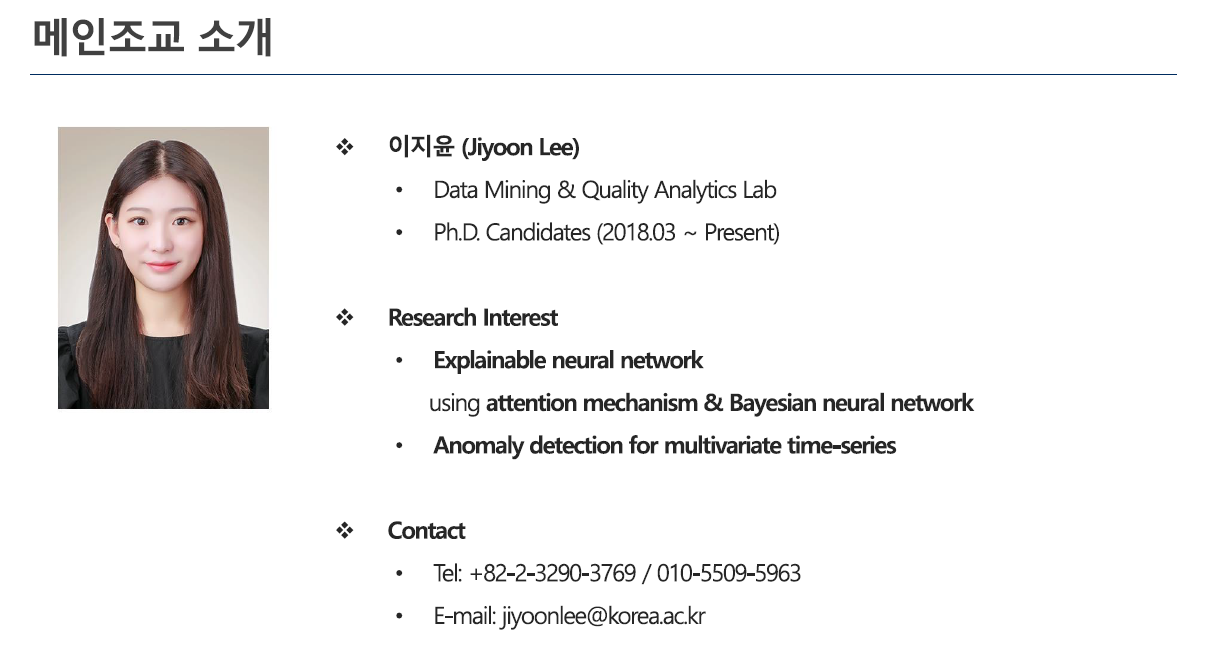

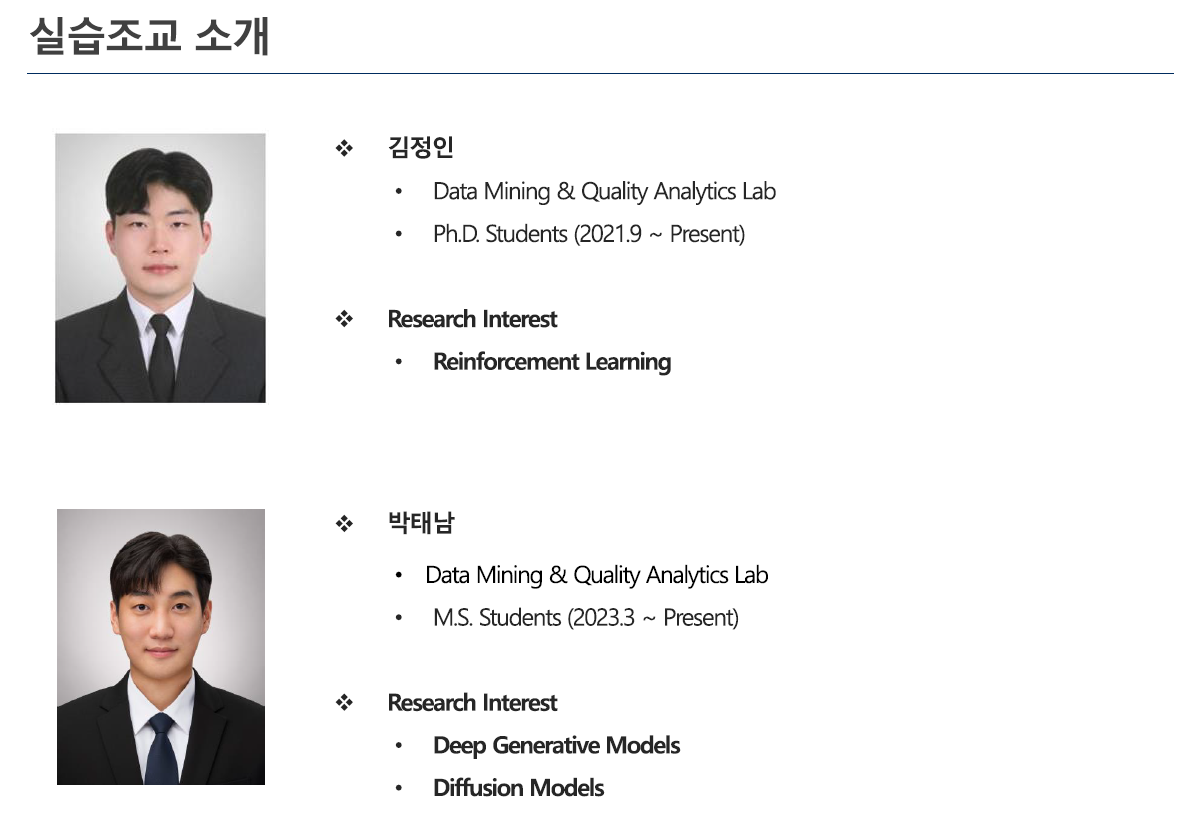

## **0. 모듈 불러오기**

In [ ]:
# terminal에서 'nvidia-smi -L' 입력
# GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-4bf5916b-84fd-d07c-dfd4-2e8ae8bc9d9c)

# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="--UUID입력--"

In [ ]:
## 파이토치 패키지 설치 코드
# !pip install torch

# pytorch 사용을 위한 패키지 불러오기
import torch

# torch에서 gpu 사용 가능한지 확인하기
# - True : gpu 사용 가능
# - False : gpu 사용 불가능
torch.cuda.is_available()

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

import time
import copy

import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt     
import itertools

import warnings
warnings.filterwarnings(action='ignore') 

## **1. 데이터 불러오기**
- https://hoya012.github.io/blog/reproducible_pytorch/

In [ ]:
# 모델링에 필요한 시드 고정
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

- https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
- 스마트폰을 허리에 착용하고 6가지 활동 (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying)을 수행할 때 측정된 센서 데이터
- 누락된 데이터에 대해 정제된 데이터
- X: 여러 실험자에 대하여 561개의 변수를 수집한 시계열 데이터
- y: 실험자의 상태 클래스 (0(Walking) / 1(Walking Upstairs) / 2(Walking Downstairs) / 3(Sitting) / 4(Standing) / 5(Laying))

In [ ]:
train = pd.read_csv('./data/cls_train.csv')
test = pd.read_csv('./data/cls_test.csv')

### **1.1 Data Exploratory Data Analysis**

In [ ]:
train.head() # 상위 5개

In [ ]:
train.tail() # 하위 5개

In [ ]:
train.shape # 데이터 차원 확인

In [ ]:
# column별 정보 출력 - 결측치, 데이터타입
train.info()

In [ ]:
# column 별 기본적인 통계 값 확인
train.describe()

In [ ]:
# 예측 대상(Y)의 클래스별 개수 확인
train['Activity'].value_counts() 

In [ ]:
x_train = train.drop(['subject', 'Activity'], axis=1)
x_test = test.drop(['subject', 'Activity'], axis=1)
y_train = train['Activity']
y_test = test['Activity']

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

## **2. 모델링을 위한 데이터 전처리**
### **2.1 Target Encoding**

In [ ]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
# 매핑되는 값 확인
name_mapping = dict(zip(label_encoder.classes_ , label_encoder.transform(label_encoder.classes_)))
print(name_mapping)

In [ ]:
# 변환된 예측 대상(Y)의 클래스별 개수 확인
print(pd.Series(y_train).value_counts())

### **2.2 Data Windowing**

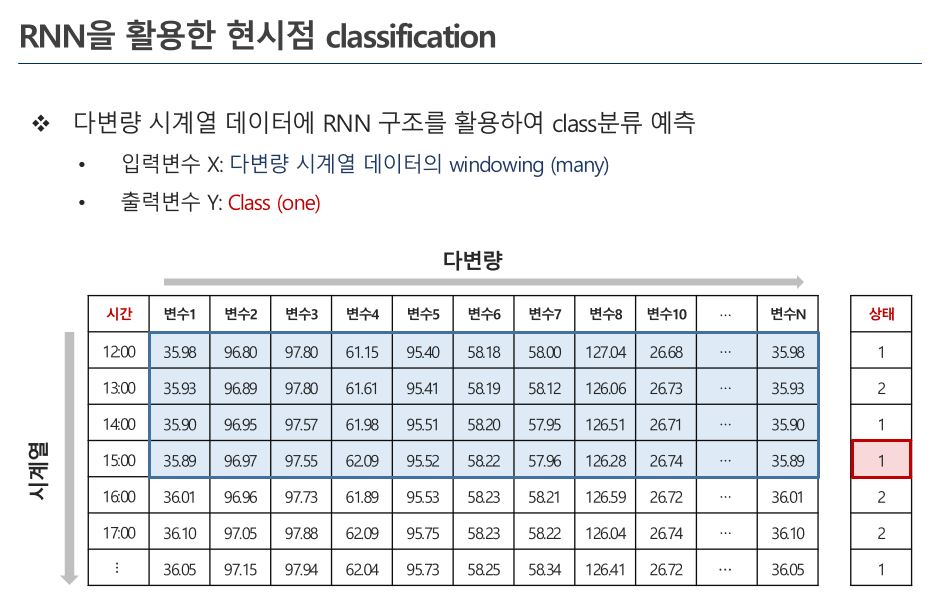

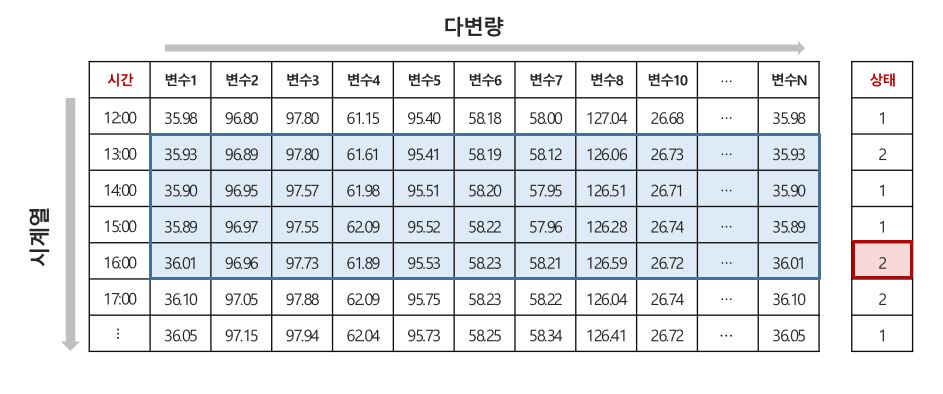

In [ ]:
def windowing_process(x, y, window_size, shift_size, last = True):
    x = x.reset_index(drop=True)
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        
        if last == True:
            y_window.append(y[start_idx + window_size - 1]) # 마지막 index의 class를 사용하는 경우
        
        else:
            count_class = Counter(y[start_idx:start_idx + window_size])
            y_window.append(count_class.most_common(n=1)[0][0]) # 가장 많이 빈출한 class를 사용하는 경우
        
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [ ]:
print('-'*35)
print('Windowing processing 전')
print('-'*35)
print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('\n')

x_train, y_train = windowing_process(x_train, y_train, 10, 1, True)
x_test, y_test = windowing_process(x_test, y_test, 10, 1, True)

print('-'*35)
print('Windowing processing 후')
print('-'*35)
print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('\n')

In [ ]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}') # (batch_size x seq_len x input_size)
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')


## **3. 순환신경망 (RNN) 모델링**
### **3.1 Define the Model Structure**
- https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

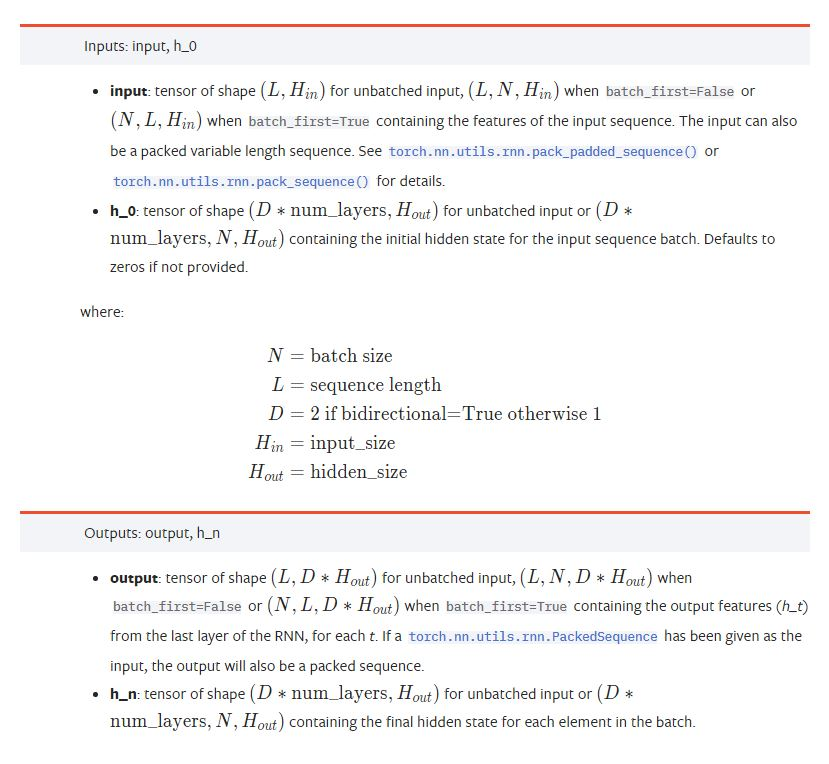

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # recurrent layer 설정
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)

        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, self.num_classes)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # RNN으로부터 output 도출
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)       
        out = self.fc(out[:, -1, :])
        return out

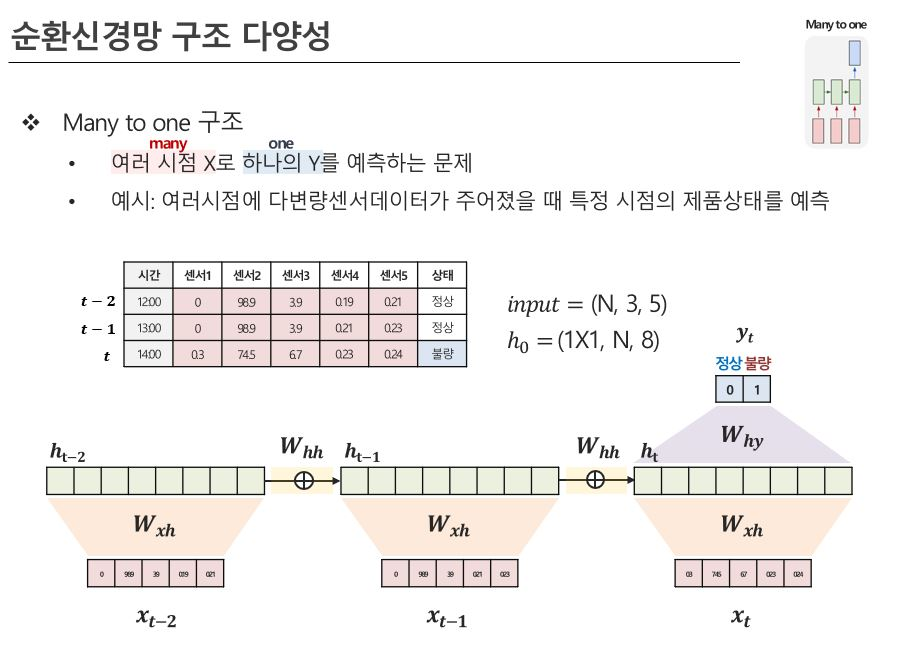

### **3.2 Define The Training Testing Strategy**


In [ ]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, num_classes, device='cuda'):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.input_size = input_size
        self.num_classes = num_classes

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        since = time.time() 

        train_loss_history = []        
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_acc = 0.0 # ACC는 클수록 좋은 metric이므로, 초기 낮은 값에서 갱신

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_corrects = 0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device, dtype=torch.long)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                        _, preds = torch.max(outputs, 1) # 첫 _에는 원래 실제 max값이 들어감 

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    running_total += labels.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                epoch_acc = running_corrects.double() / running_total

                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)


        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():
            corrects = 0
            total = 0
            preds = []
            probs = []
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.long)

                # forward
                # input을 model에 넣어 output을 도출
                outputs = model(inputs)
                prob = outputs
                prob = nn.Softmax(dim=1)(prob)
                
                # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                _, pred = torch.max(outputs, 1)
                
                # batch별 정답 개수를 축적함
                corrects += torch.sum(pred == labels.data)
                total += labels.size(0)

                preds.extend(pred.detach().cpu().numpy())
                probs.extend(prob.detach().cpu().numpy())

            preds = np.array(preds)
            probs = np.array(probs)
            acc = (corrects.double() / total).item()
       
        return preds, probs, acc

## **4. 순환신경망(RNN) 모델 학습**

### **4.1 순환신경망 (RNN) 하이퍼파라미터 설명**

- batch_size: 학습 및 검증에 사용할 배치의 크기
- input_size: 변수 개수
- num_classes: 데이터의 class 개수
- hidden_size: 모델의 hidden dimension
- num_layers: 모델의 layer 개수
- bidirectional: 모델의 양방향성 여부
- num_epochs: 학습할 epoch 횟수
- device: 사용할 자원 선정
- best_model_path: 모델 파라미터 저장 위치

In [ ]:
batch_size = 128
input_size = x_train.shape[2]
num_classes = len(np.unique(y_train))
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
best_model_path = './ckpt/rnn_cls.pt'

### **4.2 Construct Data Loaders and Model**

In [ ]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
model =  RNN_model(input_size, hidden_size, num_layers, num_classes, bidirectional, device)
model = model.to(device)

### **4.3 Model Training and Save Weights(Parameters)**

In [ ]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, num_classes, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer)

In [ ]:
# 모델 파라미터 저장
torch.save(best_model.state_dict(), best_model_path) 

## **5. Model Validation**

### **5.1 Loss History Visualization**

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Loss History')
plt.plot(range(num_epochs), train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

### **5.2 Load Model Weights(Parameters)**

In [ ]:
model.load_state_dict(torch.load(best_model_path)) # 저장된 파라미터 사용

In [ ]:
y_pred, y_prob, acc = trainer.test(model, test_loader)
print(y_pred[0])
print(y_prob[0])

In [ ]:
pd.Series(y_prob[0]).plot(kind='bar')
plt.title('Predicted probability per class')
plt.xlabel('Class')
plt.ylabel('Predicted probability')
plt.show()

### **5.3 모델 평가**

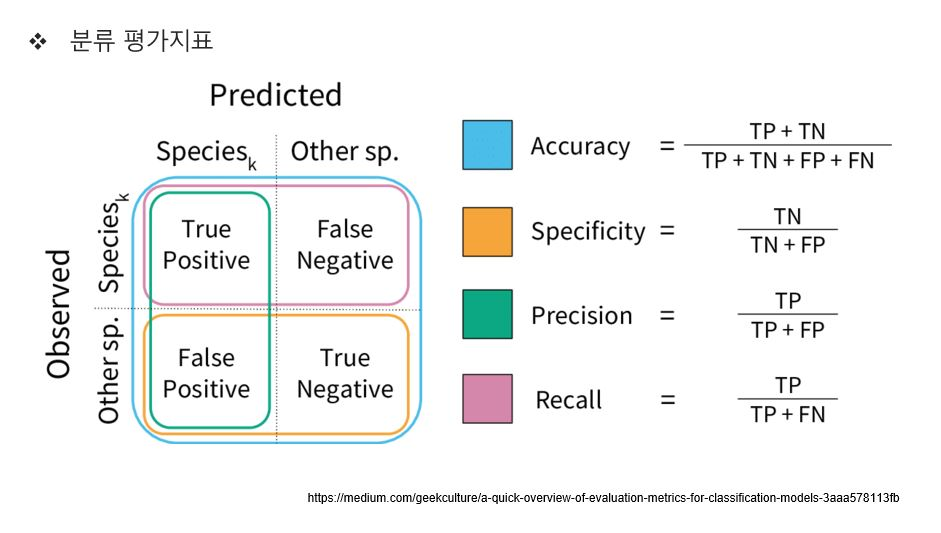

In [ ]:
cr = pd.DataFrame(classification_report(y_test, y_pred, target_names=list(label_encoder.classes_), output_dict=True))
print(cr)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.figure(figsize=(8,6))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=11)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0} (n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels, fontsize=10)
    plt.xticks(rotation=90)
    plt.yticks(marks, nlabels, fontsize=10)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(con_mat[i, j] * 100 / n), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label\n', fontsize=11)
    plt.xlabel('\nPredicted label', fontsize=11)
    plt.show()
    
plot_confusion_matrix(cm, labels=list(label_encoder.classes_), normalize=False)

# EOD